# Optimal Execution

### Mid-price model: Ornstein-Uhlenbeck (OU) Process

$$
dS_t = \theta(\mu - S_t)dt + \sigma dW_t
$$

### Execution model: Signature Speeds

In [1]:
import notebook_base

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from data.pd_vol import PDVol
from optimal_execution.sig_execution import SigExecution
import optimal_execution.utils

(CVXPY) May 25 08:42:41 PM: Encountered unexpected exception importing solver SCS:
ImportError('libmkl_rt.so.2: cannot open shared object file: No such file or directory')


### Create OU paths

In [18]:
execution_params = {
    "N": 2,
    "q0": 1.,
    "Lambda": 1e-3,
    "k": 0,
    "alpha": 10.,
    "phi": 0.,
}

# Set beta = 0 -> static vol
# Set theta = 0 -> no path-dependent drift
process_params = {
    "sigma":0.04,
    "theta":0.,
    "OU_theta":0.05,
    "alpha":0.,
    "beta":0.,
    "skew_scale":1,
    "n":200,
}

In [19]:
process = PDVol(**process_params)
paths, ES = process.build(n_paths=50000, order= 2 * (execution_params["N"] + 1) + 1, verbose = True)

Building paths:   0%|          | 0/50000 [00:00<?, ?it/s]

Computing signatures:   0%|          | 0/50000 [00:00<?, ?it/s]

In [20]:
sample = paths[:100]

## Fit the linear functional $\ell$

In [21]:
SE = SigExecution(ES, **execution_params);

In [22]:
SE.fit()
l = SE.l.value

## Analysis

In [23]:
speeds, inventories, wealths = SE.get_analytics(sample, phi=0)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

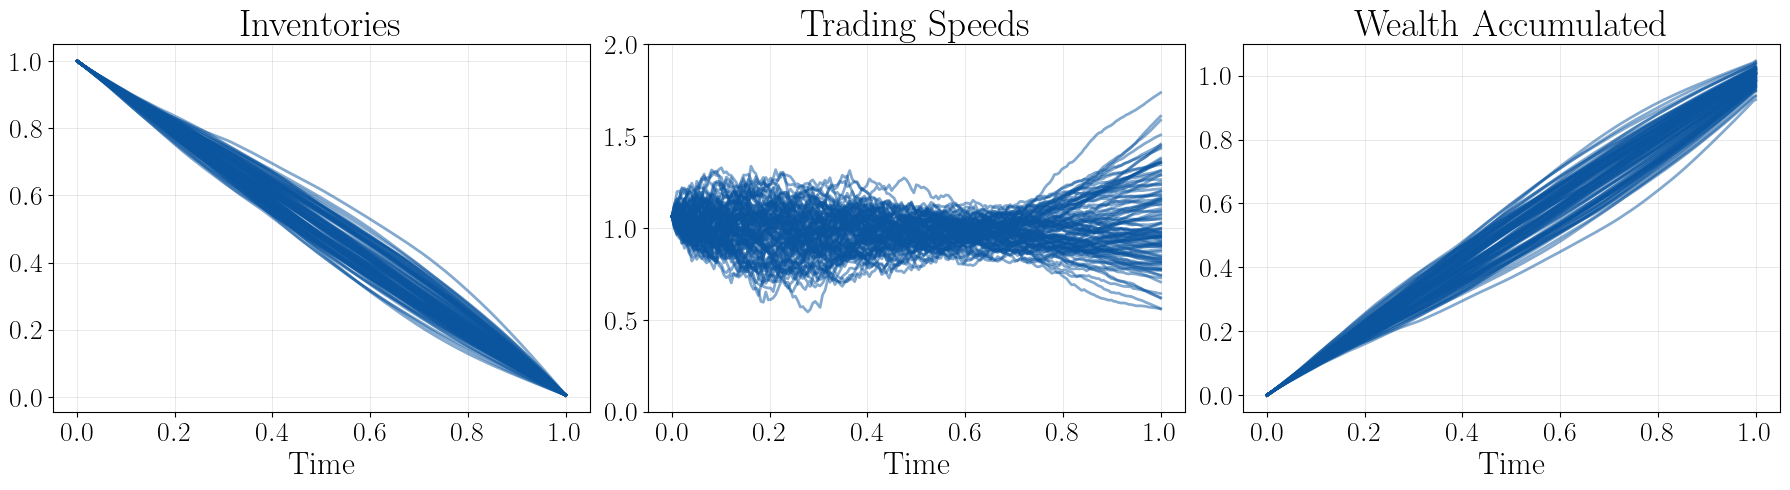

In [24]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

for Q in inventories:    
    ax[0].plot(np.linspace(0, 1, len(Q)), Q, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[0].set_title("Inventories", fontsize=27)

for theta in speeds:
    ax[1].plot(np.linspace(0, 1, len(theta)), theta, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[1].set_title("Trading Speeds", fontsize=27)
ax[1].set_ylim(0,2)

for w in wealths:    
    ax[2].plot(np.linspace(0, 1, len(w)), w, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[2].set_title("Wealth Accumulated", fontsize=27)

for i in range(3):
    ax[i].set_xlabel("Time", fontsize=14)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()

In [25]:
avg_pnl = np.stack(wealths)[:,-1].mean()-1
print(f"Average PnL at Terminal Time: {avg_pnl:.4f}")

Average PnL at Terminal Time: -0.0022


### Optimal Trading with $Q_0 = 0$ 

#### How quick should we trade based on alpha? 

- Is there a trade off between how fast our alpha is and trading "quickly"?
- If our alpha is _fast_ then we will need to trade faster, but this incurs a greater impact! Is there an optimal alpha speed for a given impact?

In [26]:
trading_params = {
    "N": 2,
    "q0": 0.,
    "Lambda": 1e-3,
    "k": 0,
    "alpha": 10.,
    "phi": 0.,
}

In [33]:
mean_rev_speeds = [0.002*i*100 for i in range(60)]
exp_wealths = []
for theta in tqdm(mean_rev_speeds):
    process_params["OU_theta"] = theta
    process = PDVol(**process_params)
    paths, ES = process.build(n_paths=5000, order= 2 * (execution_params["N"] + 1) + 1, verbose=False);
    sample = paths[:100]
    SE = SigExecution(ES, **trading_params);
    SE.fit(verbose=False);
    l = SE.l.value
    ## Analysis
    speeds, inventories, wealths = SE.get_analytics(sample, phi=0, verbose=False)
    exp_wealths.append(np.stack(wealths)[:,-1].mean())

  0%|          | 0/60 [00:00<?, ?it/s]

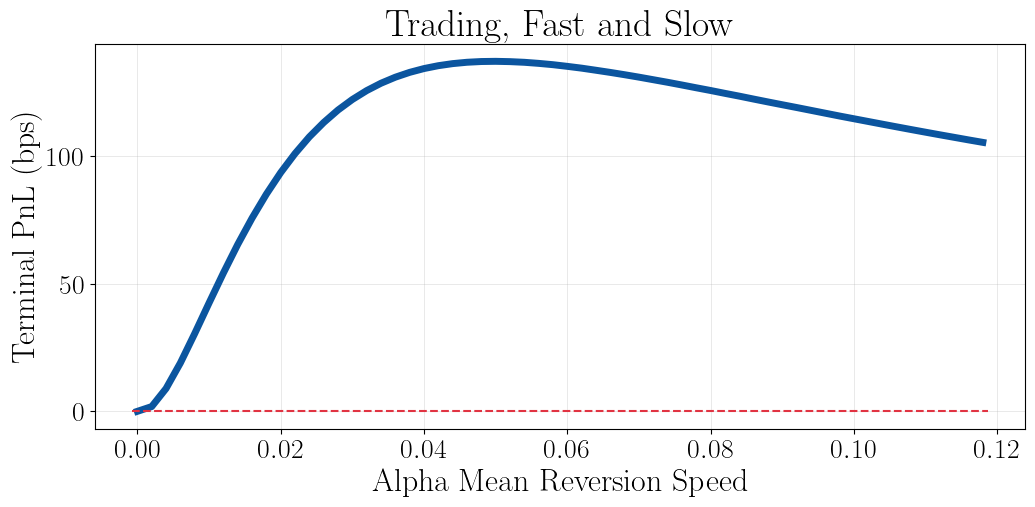

In [37]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(np.array(mean_rev_speeds)/100, np.array(exp_wealths)*10000, lw=5)
ax.set_title("Trading, Fast and Slow", fontsize=27)
ax.axhline(0, xmin=0.04,xmax=0.96, color=sns.color_palette("rocket")[3], linestyle="--", lw=1.5)
ax.set_xlabel("Alpha Mean Reversion Speed", fontsize=14)
ax.set_ylabel("Terminal PnL (bps)", fontsize=14)
ax.yaxis.label.set_size(23)
ax.xaxis.label.set_size(23)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# i].legend(fontsize=20)
ax.grid(alpha=0.4, linewidth=.5)

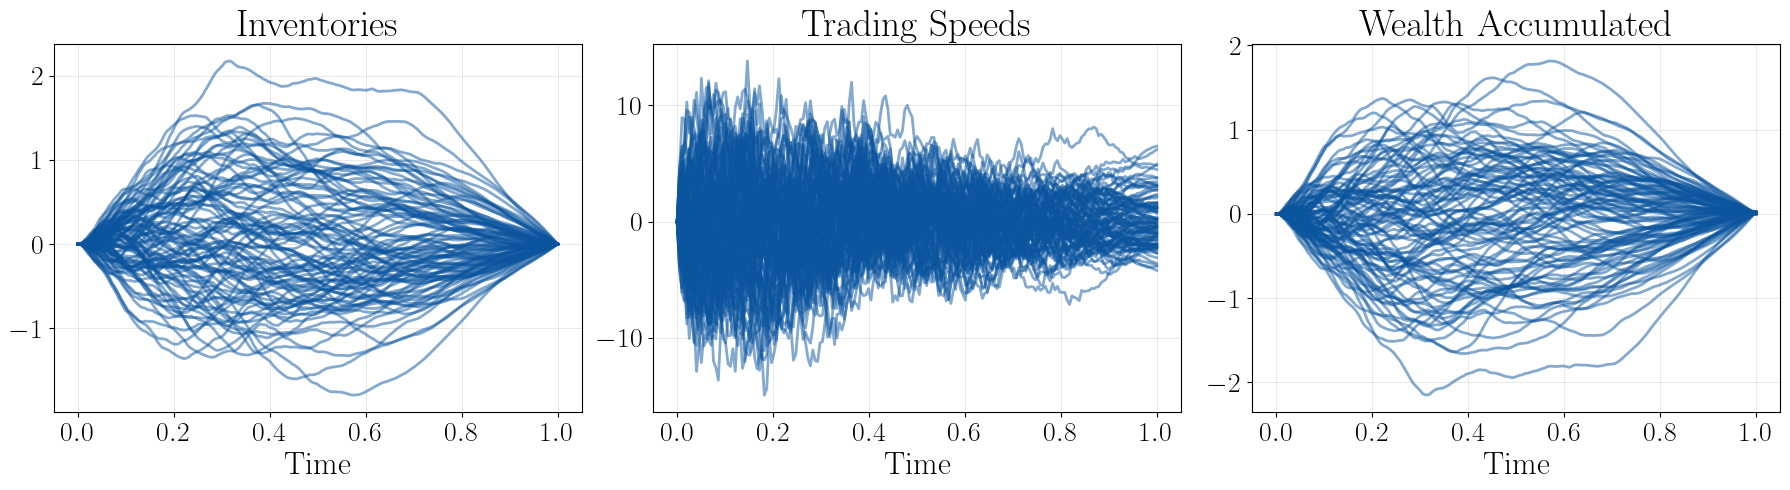

In [35]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

for Q in inventories:    
    ax[0].plot(np.linspace(0, 1, len(Q)), Q, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[0].set_title("Inventories", fontsize=27)

for theta in speeds:    
    ax[1].plot(np.linspace(0, 1, len(theta)), theta, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[1].set_title("Trading Speeds", fontsize=27)

for w in wealths:    
    ax[2].plot(np.linspace(0, 1, len(w)), w, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[2].set_title("Wealth Accumulated", fontsize=27)

for i in range(3):
    ax[i].set_xlabel("Time", fontsize=14)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()